Initial setup

In [1]:
%run "Common setup.ipynb"

C:\Users\douglasd\AppData\Local\Continuum\miniconda3\envs\biblio\lib\site-packages\fuzzywuzzy-0.17.0-py3.6.egg\fuzzywuzzy\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [2]:
RC = mk.RecordCollection("{}/rest_filtered_corpora.txt".format(TMP_DIR))

<hr> Analysing software packages in the corpora <br>


In [10]:
software_keywords = ['software', 'toolkit', 'toolbox', 'computer program']
all_uc_software = wosis.find_keywords(RC, software_keywords, threshold=95.0)

In [11]:
wosis.rc_to_df(all_uc_software).to_csv('{}/software_packages_rest.csv'.format(DATA_DIR))

    - Keyword trend 
    - Key-phrase analysis

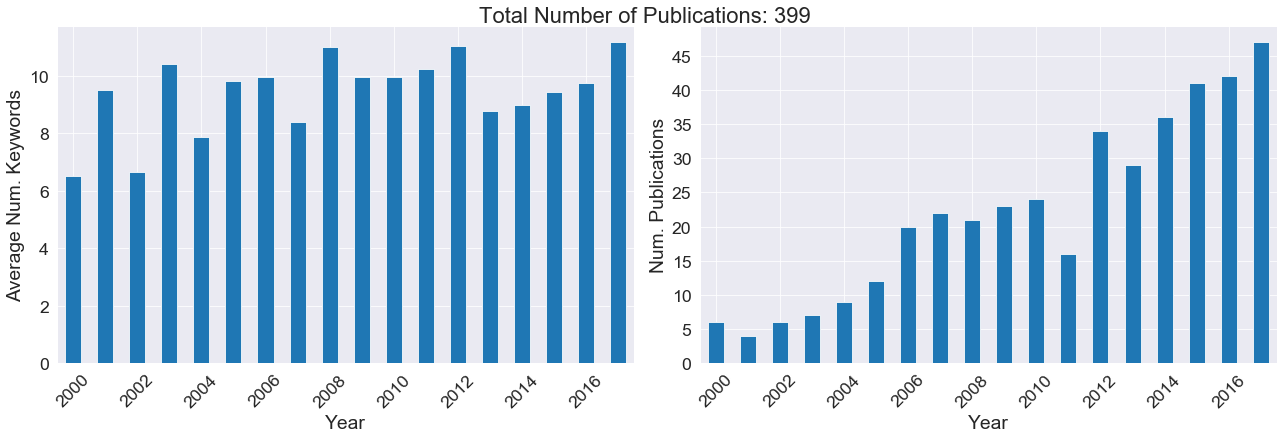

In [12]:
wos_plot.plot_kw_trend(all_uc_software)

In [13]:
software_phrases = wosis.find_phrases(wosis.rc_to_df(all_uc_software))

<hr>
Create a dataframe of relevant papers: manual sorting

In [14]:
# Export phrase data
# software_phrases.all_phrases.to_csv('{}/software_phrases_unfiltered.csv'.format(DATA_DIR))

We then sort the publications into separate topics

In [26]:
software_rc = wosis.extract_recs(software_phrases.document_ids, RC)

In [16]:
len(software_rc)

399

In [18]:
# Results are loaded from the indicated cache file in subsequent runs to ensure the same results
software_topics = wosis.find_topics(software_rc, num_topics=15, 
                                    cache_as='{}/software_topic_results_2019-03-01'.format(TMP_DIR))

Topic 1: model use paramet simul wa sensit analysi analysis data result
Topic 2: optim design optimization shape element structur method algorithm control object
Topic 3: life lca product cycl impact cycle environment assessment energi wa
Topic 4: risk assess ecolog assessment health exposur probabilist multipl potenti exposure
Topic 5: uncertainti uncertainty carlo method estim propag mont quantification sampl monte
Topic 6: reactor reaction kinet solar chemic hydrogen carbon experiment wa degrad
Topic 7: swat sediment soil catchment hydrolog watersh river calibr model eros
Topic 8: water crop lake groundwat qualiti flux irrig surfac climat river
Topic 9: flood urban map hazard gis event area wa surfac upstream
Topic 10: flow channel diffus control wa river pump calibr predict stream
Topic 11: adjoint direct kpp method solv differenti sensit problem chemic deriv
Topic 12: toolbox matlab interface ord multivari order calibr sampl graphic second
Topic 13: thermal heat comfort build temp

The above results appear to indicate that 

* Topic 1 is related to model sensitivity
* Topic 2 is relevant to optimization studies
* Topic 5 is relevant to uncertainty quantification
* Topic 12 is relevant to Matlab toolboxes

In [22]:
topic_ids_of_interest = {
    'sa': 1,
    'optimization': 2,
    'uq': 5,
    'toolbox': 12
} 

software_topic_dfs = {k: software_topics.get_topic_by_id(i) for k, i in topic_ids_of_interest.items()}

# Create DOI columns
software_topic_dfs = {k: wosis.link_to_pub(wosis.extract_recs(df.id, software_rc)) for k, df in software_topic_dfs.items()}

In [23]:
for topic_name, df in software_topic_dfs.items():
    print('{}:'.format(topic_name), len(df))
    
print('Total:', sum([len(df) for df in software_topic_dfs.values()]))

sa: 178
optimization: 37
uq: 30
toolbox: 9
Total: 254


We can then qualitatively look at the above results aided by key phrase extraction

In [27]:
sa_rc = wosis.extract_recs(software_topic_dfs['sa'].id, software_rc)
uq_rc = wosis.extract_recs(software_topic_dfs['uq'].id, software_rc)
sa_uq = sa_rc + uq_rc

sa_uq_df = wosis.rc_to_df(sa_uq)

In [28]:
uasa_phrases = wosis.find_phrases(sa_uq_df, 
                                  weighted_keywords=['software', 'toolkit', 'toolbox', 'package', 'sensitivity', 
                                                     'uncertainty'])

An unfiltered dataset is exported for transparency followed by a copy that will be manually sorted and modified

In [29]:
uasa_phrases.all_phrases.to_csv('{}/uasa_software_phrases_unsorted.csv'.format(DATA_DIR))

The above dataset is then qualitatively examined to identify papers that either introduces software, code, or applies an existing software package for UA/SA.

Once the manual process is complete, the file `uasa_software_phrases_sorted.csv` is overwritten with an additional column "relevant".

A simple "Yes" and "No" is used to indicate whether the study applied software.

An effort is made to identify the software. Otherwise a simple "Yes" indicates that UA/SA was conducted with some method named, but no software clearly indicated.

In some cases the article was not related to the field of environmental modeling and so is marked with a "No (not related to environment)". Reviews and discussion papers were also marked with "No"

Cases where it was not immediately clear what was done - if UA/SA software was used or if/how it was conducted - are marked with a '?' (some papers may simply state something to the effect of 'sensitivity analysis was applied').


In [15]:
# prev_sorted = pd.read_csv('{}/uasa_software_phrases_sorted_2019-03-01.csv'.format(DATA_DIR))
# new_file = pd.read_csv('{}/uasa_software_phrases_sorted_2019-03-01up.csv'.format(DATA_DIR))
# combined = wosis.combine_manually_sorted(new_file, prev_sorted)
# combined.to_csv('{}/uasa_software_phrases_sorted_2019-03-01.csv'.format(DATA_DIR), index=False)

In [34]:
sorted_software = pd.read_csv('{}/uasa_software_phrases_sorted_2019-03-01.csv'.format(DATA_DIR))

In [35]:
is_relevant = sorted_software.relevant.str.contains("Yes") == True
not_relevant = sorted_software.relevant.str.contains("No") == True
unknown_relevance = sorted_software.relevant.str.contains("\?") == True
not_sorted = sorted_software.relevant.isnull() == True

print("{} papers are relevant".format(len(sorted_software[is_relevant])))
print("{} papers are not relevant".format(len(sorted_software[not_relevant])))
print("{} papers have unknown relevance".format(len(sorted_software[unknown_relevance])))
print("{} papers are not sorted".format(len(sorted_software[not_sorted])))

98 papers are relevant
78 papers are not relevant
31 papers have unknown relevance
0 papers are not sorted


In [36]:
relevant_papers = sorted_software[is_relevant]

In [37]:
# We need to remove the year that helpfully gets added to title
title_list = sorted_software[is_relevant].title.tolist()
title_list = [' '.join(t.split(' ')[0:-1]) for t in title_list]

relevant_pubs = wosis.find_pubs_by_title(software_RC, title_list)

In [38]:
pubs = wosis.link_to_pub(wosis.rc_to_df(relevant_pubs))

In [40]:
pubs.loc[:, ~pubs.columns.isin(HIDE_COLUMNS)].to_csv('{}/relevant_UASA_software_papers.csv'.format(DATA_DIR))